<a href="https://colab.research.google.com/github/churry75/tf_tutorial/blob/master/tf_tutorial_07_tf_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 텐서플로우 데이터셋 API를 이용하여 데이터셋 불러오기


In [91]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

- CIFAR-10 데이터셋 사용
    - 10 개의 클래스에있는 60000 개의 32x32 컬러 이미지로 구성
    - 클래스 당 6000 개의 이미지
    - 50000 개의 훈련 이미지
    - 10000 개의 테스트 이미지

- 텐서플로우 데이터셋을 이용하기 위해서는 `tensorflow_datasets` 라이브러리를 설치해야 함
    - `pip install --user tensorflow-datasets`

In [92]:
import tensorflow_datasets as tfds

## 데이터 스플릿

### split 인자 사용 x

In [93]:
data_sets = tfds.load(name='cifar10')
train_sets, test_sets = data_sets['train'], data_sets['test']
train_sets

<PrefetchDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>

### split 인자 사용 - 1
- 데이터셋이 훈련, (평가), 테스트 용으로 나눠져 있을 경우 사용 가능
- 텐서플로우 데이터셋 홈페이지에서 확인 가능 => [홈페이지 링크](https://www.tensorflow.org/datasets/catalog/overview?hl=ko)

In [94]:
train_sets = tfds.load(name='cifar10', split='train')
test_sets = tfds.load(name='cifar10', split='test')
train_sets

<PrefetchDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>

### split 인자 사용 - 2
- split 인자 안에 리스트 형태로 key 값을 넣어주어 한 번에 분류 가능

In [95]:
train_sets, test_sets = tfds.load(name='cifar10', split=['train',  'test'])
train_sets

<PrefetchDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>

### split 인자 사용 - 3
- key 값을 슬라이싱 하여 원하는 크기로 분류
- 텐서플로우에서 제공해주는 기능으로 슬라이싱 크기를 %로 지정할 수 있다.

In [96]:
train_sets, valid_sets, test_sets = tfds.load(name='cifar10', split=['train[:85%]', 'train[85%:]', 'test'])
train_sets

<PrefetchDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>

## 데이터 정보 확인

- 데이터 로드를 할때 `with_info=True` 인자를 통해서 데이터셋의 정보를 알 수 있음
- 또한, 아래와 같이 텐서플로우의 데이터셋은 딕셔너리 형태로 구성되어 있음을 확인

In [97]:
data_sets, info = tfds.load(name='cifar10', with_info=True)

In [98]:
info.splits

{'test': <tfds.core.SplitInfo num_examples=10000>,
 'train': <tfds.core.SplitInfo num_examples=50000>}

- 클래스 이름 확인

In [99]:
class_names = info.features['label'].names
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## 데이터 셔플

- load 함수에서, `shuffle_files` 인자를 `True`로 설정하면 다운로드한 파일을 섞을 수 있음 

In [100]:
train_sets, test_sets = tfds.load(name='cifar10', split=['train',  'test'], shuffle_files=True)

- 그러나 셔플량이 충분하지 않기 때문에 아래와 같이 추가로 더 섞는 것을 권장
    ```python
    train_sets = train_sets.shuffle(100000)
    ```

    - 또한, 원하는 batch 크기를 지정할 수 있고, prefetch 여부도 지정할 수 있음

In [101]:
train_sets = train_sets.shuffle(10000).batch(128).prefetch(1)
test_sets = test_sets.shuffle(10000).batch(128).prefetch(1)

## 이미지 전처리

- 아래와 같은 함수를 통해 이미지 전처리 수행
    - 분류된 데이터셋을 *'이미지'*와 *'레이블'*로 나눠줌
    - 또한, re-size 혹은 정규화 등의 작업을 수행

In [102]:
def preprocessing(item):
    images = item['image']
    # image resize
    images = tf.image.resize(images, [32, 32])
    # image normalization
    images = tf.cast(images, tf.float32) / 255.0
    labels = item['label']
    return images, labels

In [103]:
train_sets = train_sets.map(preprocessing)
test_sets = test_sets.map(preprocessing)
train_sets

<MapDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int64)>

In [104]:
for image, label in train_sets.take(1):
    print(image.shape)
    print(label.shape)

(128, 32, 32, 3)
(128,)


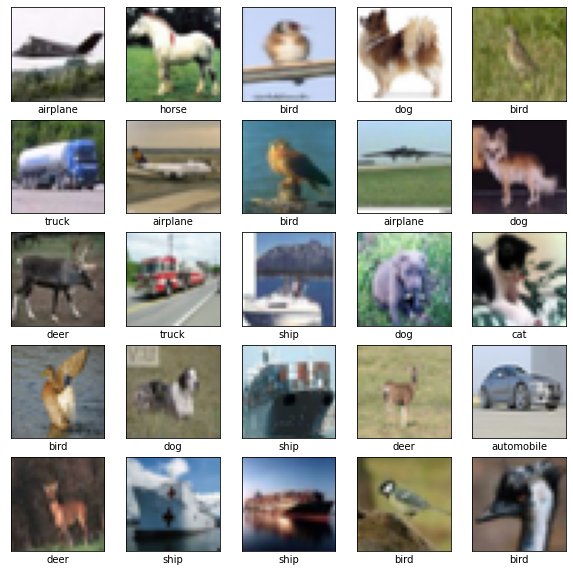

In [105]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image[i])
    plt.xlabel(class_names[label[i]])
plt.show()

## 데이터셋 이미지, 레이블 분리



- 레이블링이된 데이터 셋에 한해서, \
`as_supervised` 인자를 `True`로 설정하면 데이터를 이미지와 레이블로 바로 분리 할 수 있다.

In [135]:
train_data, valid_data, test_data = tfds.load(name='cifar10', split=['train[:85%]', 'train[85%:]', 'test'], as_supervised=True)

In [136]:
train_data

<PrefetchDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>

- 위의, `as_supervised`를 지정하지 않은 출력과 비교해 보면,
    - 위의 경우 'id', 'image', 'label'의 딕셔너리로 구성되어 있다면,
    - 이 경우에는 **튜플** 형태로 구성되어 있음을 볼 수 있다.
    > 케라스에서는 튜플 형태의 데이터를 입력 받기 때문에, 딕셔너리 형태를 위의 map() 메서드를 이용하여 튜플 형태로 변환해준 것을 기억하자
        - map() 메서드를 이용하여 (이미지, 라벨) 형태로 변환하기 위한 방법 - lambda 이용
    ```python
    train_sets = train_sets.map(lambda items: (items['image'], items['label']))
    ```
    
    - 따라서, 반복문으로  image와 label을 나눠주지 않아도 바로 모델의 input 데이터로 사용할 수 있다.
        > 아래는 그래프를 그리고 크기를 확인하기 위한 예시를 위해 나눠주었다.

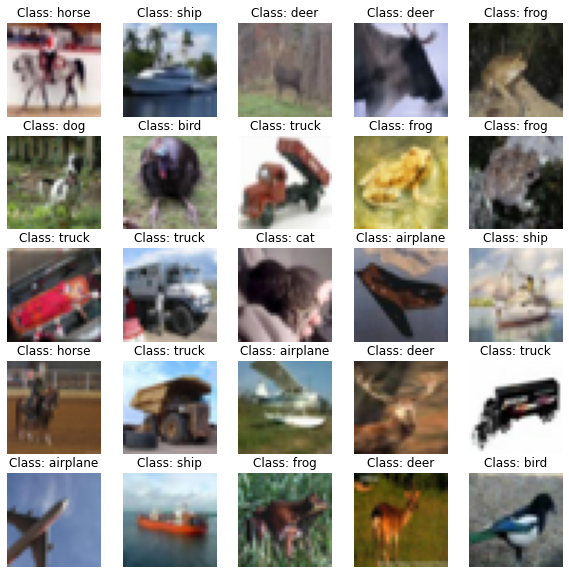

In [137]:
plt.figure(figsize=(10, 10))
index = 0
for images, labels in train_data.take(25):
    index += 1
    plt.subplot(5, 5, index)
    plt.imshow(images)
    plt.title("Class: {}".format(class_names[labels]))
    plt.axis("off")
plt.show()

In [138]:
for images, labels in train_data.take(1):
    print(images.shape)
    print(labels.shape)

(32, 32, 3)
()


- 또한, `batch_size` 를 지정해주면 배치를 바로 만들 수 있다.

In [124]:
train_data, valid_data, test_data = tfds.load(name='cifar10', split=['train[:85%]', 'train[85%:]', 'test'], as_supervised=True, batch_size=128)

In [125]:
train_data

<PrefetchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.uint8, tf.int64)>

In [126]:
for images, labels in train_data.take(1):
    print(images.shape)
    print(labels.shape)

(128, 32, 32, 3)
(128,)


## image normalization 방법
- tf.cast 함수 이용

In [ ]:
for item in train_sets.take(1):
    ori_images = item['image']
    norm_images = tf.cast(ori_images, tf.float32) / 255.0
    labels = item['label']
    print(ori_images)
    print(norm_images)

## image 전처리 함수 생성 후 이를 이용

In [ ]:
def preprocessing(item):
    images = item['image']
    # image resize
    images = tf.image.resize(images, [224, 224])
    # image normalization
    images = tf.cast(images, tf.float32) / 255.0
    labels = item['label']
    return images, labels

In [ ]:
train_sets = train_sets.map(preprocessing).shuffle(10000).batch(32)
train_sets